<div class='alert alert-info' style='font-family:Arial; font-size:16px' ><center><font size="5"> Detailed Methdology: Implemention of the National Institutes of Health - National COVID Cohort Collaborative (N3C) Machine Learning PASC/Long COVID Phenotype Algorithm in the <font><i>All of Us</font> Researcher Workbench </font></center></div>

**Created by** 

*All of Us* (Data and Research Center, Vanderbilt University Medical Center): Wei-Qi Wei, Srushti Gangireddy, Hiral Master, Eric Kerchberger

*National COVID Cohort Collaborative (N3C)*: Emily Pfaff (University of North Carolina at Chapel Hill), Andrew Girvin (Palantir), Miles Crosskey (CoVar), Melissa Haendel (University of Colorado Anschutz Medical Campus), Chris Chute (John Hopkins University)

*PCORnet*: Mark Weiner (Weill Cornell Medical College)

*NIH/RECOVER*: Josh Fessel (NIH/NCATS, RECOVER - EHR/RWD Scientific Program Lead), Gabriel Anaya (NIH/NHLBI, RECOVER - EHR/RWD Scientific Program Lead), Michelle Olive (NIH/NHLBI, RECOVER - EHR/RWD Co-Scientific Program Director), Lisa Schwartz Longacre (NIH/NHLBI, RECOVER - EHR/RWD Co-Scientific Program Director)

*Deloitte*: Chelsea Powell, Meenakshi Kalera

Contact information: Hiral Master (hiral.master@vumc.org), Gabriel Anaya (gabriel.anaya@nih.gov)

# Objective

The objective of this notebook is to provide detailed methodology on how N3C RECOVER's Long COVID algorithm (in PySpark) is implemented within Researcher Workbench Jupyter Notebook using Python Programming.

The XGBoost machine learning model was used to identify potential patients with PASC/Long COVID, which was initially published by [Emily et al](https://pubmed.ncbi.nlm.nih.gov/35589549/). These models were initially implemented within the *All of Us* Controlled Tier data (C2022Q2R2; v6), which was last refreshed on June 22, 2022.

In this notebook, we will show the following:
1. All the libraries that are needed to implement N3C RECOVER's Long COVID algorithm within Researcher Workbench.   
2. Detailed steps on how the ML model was implemented in the *All of Us* Researcher Workbench using Python programming language. 
3. How to compute demographic characteristics of the final analytical sample on N3C RECOVER's Long COVID algorithm.  

## Setup

What libraries and software packages are needed to implement the algorithm. 

## Algorithm Code

The orginial code was in PySpark and we present all steps needed to run this algorithm within pandas. Further, we show detailed methodology on how to create the analytical dataset, which meets the criteria on which the alogrithm can be applied. Specifically, the model was run on participants who were identified as having a COVID positive value based on "condition" and "laboratory" results (in the Electronic Health Records (EHR)). Additionally, participants needed to have enough medication or diagnostic data (i.e., one positive PCR or antigen test, at least 145 days have passed since COVID-19 index date and who have had at least one healthcare encounter between days 45 and 300 from their COVID-19 index date)

## Analysis and Results

Identify the distribution of probabilities of having Long COVID using the algorithm and the demographic characteristics of analytical sample.

# Set Up

## Libraries that were installed in this notebook to implement the algorithm

In [ ]:
# %%capture

# # Install specific packages/version
# !pip install numpy==1.19.5
# !pip install scipy==1.5.3
# !pip install scikit-learn==0.23.2
# !pip install shap==0.39.0
# !pip install xgboost==1.4.2
# !pip install matplotlib==2.2.4
# !pip install seaborn==0.11.2

## Importing all the necessary libraries to implement the algorithm

In [ ]:
from google.cloud import bigquery
import pandas as pd
import polars as pl
import numpy as np
import scipy
import sklearn
import xgboost as xgb
import matplotlib as mpl
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
bucket = os.getenv("WORKSPACE_BUCKET")
bucket

In [ ]:
# show all columns in pandas
pd.set_option("display.max_columns", None)

# show full column width
pd.set_option('display.max_colwidth', 100)

# Polars string length to 100
pl.Config.set_fmt_str_lengths(100)

# Set the row limit to a higher value
pl.Config.set_tbl_rows(50)

## Importing the dataset within the notebook

In [ ]:
CDR = os.environ["WORKSPACE_CDR"]

In [ ]:
CDR

# Helper Functions

In [ ]:
def polars_gbq(query):
    """
    Execute a BigQuery SQL query and return results as a polars dataframe
    :param query: BigQuery SQL query
    :return: polars.DataFrame
    """
    client = bigquery.Client()
    query_job = client.query(query)
    rows = query_job.result()
    df = pl.from_arrow(rows.to_arrow())

    return df

# PySpark Code translated to Pandas to facililate the implementation of the N3C algorithm within this notebook

## Macrovisits SQL

OMOP and other common data models do not enforce a definition for a "visit." In order to make sure N3C code is reproducible, we need to ensure that we define a visit in the same way that they do. *This code will not change anything in the existing `VISIT_OCCURRENCE` table, but rather will create a new table to contain `macrovisits`, or `visits defined using the N3C definition`.

Since we cannot currently create intermediate tables within the notebook, we have implemented a workaround. Specifically, in the next couple of rows, i.e., In [5] to In [8], we have created temporary tables in a transaction so we are able to pull the data we need into the dataframe, which is necessary to implement the N3C algorthim.

In [ ]:
inpatient_microvisits_sql = f"""
SELECT * FROM `{CDR}`.visit_occurrence WHERE
(visit_start_date IS NOT NULL AND visit_end_date IS NOT NULL)
AND visit_start_date <= visit_end_date AND (visit_concept_id in (9201, 8717, 262, 32037, 581379) -- IP, Inpatient Hospital, Emergency Room and Inpatient Visit, Intensive Care, Inpatient Critical Care Facility  
or (visit_concept_id = 9202 AND DATE_DIFF(visit_end_date,visit_start_date, DAY) = 1) -- Outpatient Visit
or (visit_concept_id = 9203 AND DATE_DIFF(visit_end_date,visit_start_date, DAY) >= 1)) -- Emergency Room Visit
"""

In [ ]:
merging_intervals_sql = f"""
with inpatient_microvisits as 
({inpatient_microvisits_sql}),
merging_intervals_a as 
(
SELECT  person_id, visit_start_date, visit_end_date,
MAX(visit_end_date) OVER (PARTITION BY person_id ORDER by visit_start_date) AS max_end_date, 
RANK() OVER (PARTITION BY person_id ORDER by visit_start_date) AS rank_value
FROM inpatient_microvisits
),
merging_intervals_b as 
(
 SELECT  *, CASE WHEN visit_start_date <= LAG(max_end_date) OVER (PARTITION BY person_id ORDER by visit_start_date) THEN 0 ELSE 1
END AS gap FROM merging_intervals_a
),
merging_intervals_c as 
(
SELECT *, SUM(gap) OVER (PARTITION BY person_id ORDER by visit_start_date) AS group_number FROM merging_intervals_b
)
SELECT  person_id, group_number, MIN(visit_start_date) AS macrovisit_start_date, MAX(visit_end_date) AS macrovisit_end_date,
CONCAT(person_id, '_', group_number, '_', ABS(MOD(FARM_FINGERPRINT(STRING(min(visit_start_date))), 10))) AS macrovisit_id
FROM merging_intervals_c
GROUP BY person_id, group_number
ORDER BY person_id, group_number
"""

In [ ]:
initial_macrovisits_with_microvisits_sql = f"""
with merging_intervals as
({merging_intervals_sql})
SELECT  v.person_id, v.provider_id, v.visit_occurrence_id, v.visit_concept_id, m.macrovisit_id, m.macrovisit_start_date, m.macrovisit_end_date
FROM `{CDR}`.visit_occurrence v LEFT JOIN merging_intervals m
ON v.person_id = m.person_id
AND v.visit_start_date >= m.macrovisit_start_date
AND v.visit_start_date <= m.macrovisit_end_date
"""

In [ ]:
final_microvisits_to_macrovisits_sql = f"""
BEGIN TRANSACTION;
create TEMP TABLE microvisits_to_macrovisits as 
with initial_macrovisits_with_microvisits as
({initial_macrovisits_with_microvisits_sql}),
ip_and_er_microvisits AS
(
    SELECT DISTINCT macrovisit_id
    FROM initial_macrovisits_with_microvisits
    WHERE visit_concept_id IN (9201, 8717, 262, 32037, 581379, 9203)
),
macrovisits_containing_at_least_one_ip_visit AS
(
    SELECT m.* 
    FROM initial_macrovisits_with_microvisits m
    INNER JOIN ip_and_er_microvisits i
    ON m.macrovisit_id = i.macrovisit_id
)
SELECT v.*,
        m.macrovisit_id,
        m.macrovisit_start_date,
        m.macrovisit_end_date
FROM `{CDR}`.visit_occurrence v
LEFT JOIN macrovisits_containing_at_least_one_ip_visit m
ON v.visit_occurrence_id = m.visit_occurrence_id;
COMMIT TRANSACTION;
select * from microvisits_to_macrovisits;
"""

## Define the cohort and pull their features

In [ ]:
# concept_sql = f"""
# SELECT 
#     DISTINCT concept_id,
#     concept_code,
#     concept_name
# FROM {CDR}.concept
# WHERE concept_id IN(37311061)
# """
# covid_tests = polars_gbq(concept_sql)

In [ ]:
# covid_tests.slice(0,50)

In [ ]:
cohort_and_features_sql = f"""

{final_microvisits_to_macrovisits_sql}

BEGIN TRANSACTION;
create TEMP TABLE feature_table_builder as 
with Positive_Results as (
select concept_id from `{CDR}`.concept
where concept_id IN (9191,4126681,36032716,36715206,45878745,45881802,45877985,45884084)
  -- original concept_ids corresponding to Positive, Detected, Presumptive positive, Abnormal, Reactive
),
COVID_Tests as (
select concept_id from `{CDR}`.concept
where concept_id IN (586520,586523,586525,586526,586529,706157,706159,715261,715272,723470,723472,757678,36032061,36032174,36032258,36661371,586518,586524,706154,706175,723464,723467,723478,36031453,586516,706158,706160,706163,706171,706172,715260,723469,36031213,36661377,586528,706161,706165,706167,723463,723468,723471,757677,36031238,36031944,586519,706166,706169,706173,723465,723476,757685,36031506,706155,706156,706170,723466,36031652,36661370,706168,706174,715262,723477,36032419,36661378,37310257)
),
u099 as (
SELECT co.person_id, min(co.condition_start_date) as u099_idx
FROM `{CDR}`.condition_occurrence co 
WHERE co.condition_concept_id IN (710706,705076) or co.condition_source_value LIKE '%U09.9%'
GROUP BY co.person_id
),
u07_any as (
SELECT co.person_id, min(co.condition_start_date) as u07_any_idx
FROM `{CDR}`.condition_occurrence co 
WHERE co.condition_concept_id = 37311061 
GROUP BY co.person_id
),
COVID_Lab_Index as (
SELECT m.person_id, min(m.measurement_date) as pos_test_idx
FROM `{CDR}`.measurement m JOIN COVID_Tests p on m.measurement_concept_id = p.concept_id
JOIN Positive_Results pr on m.value_as_concept_id = pr.concept_id
GROUP BY m.person_id
),
person_union as (
SELECT person_id FROM u07_any
UNION distinct
SELECT person_id FROM u099
UNION distinct
SELECT person_id FROM COVID_Lab_Index
),
All_Index_Dates as (
SELECT pu.person_id, lp.pos_test_idx, ua.u07_any_idx, u9.u099_idx
FROM person_union pu LEFT JOIN u099 u9 ON pu.person_id = u9.person_id
LEFT JOIN u07_any ua ON pu.person_id = ua.person_id
LEFT JOIN COVID_Lab_Index lp ON pu.person_id = lp.person_id
),
Collect_the_Cohort as (
SELECT distinct 
    pr.person_id, 
    (2023 - pr.year_of_birth) as apprx_age,
  -- updated to 2023 for v8
    (select concept_name from `{CDR}`.concept where concept_id=gender_concept_id) as sex,
    (select concept_name from `{CDR}`.concept where concept_id=race_concept_id) as race, 
    (select concept_name from `{CDR}`.concept where concept_id=ethnicity_concept_id) as ethn, 
    pr.care_site_id as site_id,                            
    LEAST(IFNULL(vc.pos_test_idx, CURRENT_DATE()), IFNULL(vc.u07_any_idx, CURRENT_DATE())) as min_covid_dt
FROM All_Index_Dates vc 
    JOIN `{CDR}`.person pr ON vc.person_id = pr.person_id
    LEFT JOIN `{CDR}`.death d ON vc.person_id = d.person_id
WHERE
    date_diff('2023-10-01',LEAST(IFNULL(vc.pos_test_idx, CURRENT_DATE()), IFNULL(vc.u07_any_idx, CURRENT_DATE()), IFNULL(d.death_date, CURRENT_DATE())), DAY) >= 100
  -- changed to 2023-10-01 for v8
),
Hospitalized_Cases as (
SELECT b.person_id, b.apprx_age, b.sex, b.race, b.ethn, site_id, min_covid_dt
FROM Collect_the_Cohort b JOIN microvisits_to_macrovisits mac ON b.person_id = mac.person_id
WHERE
    mac.macrovisit_start_date between DATE_SUB(b.min_covid_dt, INTERVAL 14 DAY) and DATE_ADD(b.min_covid_dt, INTERVAL 14 DAY)
UNION ALL
SELECT b.person_id, b.apprx_age, b.sex, b.race, b.ethn, site_id, min_covid_dt
FROM Collect_the_Cohort b JOIN microvisits_to_macrovisits mac ON b.person_id = mac.person_id
    JOIN `{CDR}`.condition_occurrence cond ON mac.visit_occurrence_id = cond.visit_occurrence_id
WHERE
    mac.macrovisit_id is not null
    and condition_concept_id = 37311061 
),
hosp_and_non as (
SELECT ctc.*,
case when hc.person_id is not null 
    then 'CASE_HOSP' else 'CASE_NONHOSP' end as patient_group
FROM Collect_the_Cohort ctc
    LEFT JOIN Hospitalized_Cases hc ON ctc.person_id = hc.person_id
)
SELECT * FROM 
(SELECT ottbl.*, IFNULL(count(distinct visit_start_date),0) as post_visits_count, 
date_diff(ottbl.post_window_end_dt,ottbl.post_window_start_dt, DAY) as tot_post_days, 
IFNULL(count(distinct visit_start_date),0)/300 as post_visits_per_pt_day FROM 
(SELECT distinct 
hc.*, 
date_diff(max(mm.visit_start_date),min(mm.visit_start_date), DAY) as tot_long_data_days, 
DATE_SUB(hc.min_covid_dt, INTERVAL 365 DAY) as pre_window_start_dt, 
DATE_SUB(hc.min_covid_dt, INTERVAL 45 DAY) as pre_window_end_dt, 
DATE_ADD(hc.min_covid_dt, INTERVAL 45 DAY) as post_window_start_dt, 
case when DATE_ADD(hc.min_covid_dt, INTERVAL 300 DAY) < '2023-10-01' 
then DATE_ADD(hc.min_covid_dt, INTERVAL 300 DAY) 
else '2023-10-01' end as post_window_end_dt
  -- dates updated to 2023-10-01 for v8
FROM hosp_and_non hc JOIN microvisits_to_macrovisits mm ON hc.person_id = mm.person_id
LEFT JOIN All_Index_Dates lc ON hc.person_id = lc.person_id
GROUP BY
hc.person_id, hc.patient_group, hc.apprx_age, hc.sex, hc.race, hc.ethn, hc.site_id, hc.min_covid_dt, lc.u099_idx
) ottbl
LEFT JOIN microvisits_to_macrovisits mmpost ON (ottbl.person_id = mmpost.person_id and mmpost.visit_start_date between ottbl.post_window_start_dt and 
ottbl.post_window_end_dt and mmpost.macrovisit_id is null)
WHERE tot_long_data_days > 1 
GROUP BY ottbl.person_id, ottbl.patient_group, ottbl.apprx_age, ottbl.sex, ottbl.race, ottbl.ethn, ottbl.site_id, ottbl.min_covid_dt, ottbl.tot_long_data_days, ottbl.pre_window_start_dt, ottbl.pre_window_end_dt, 	
ottbl.post_window_start_dt, ottbl.post_window_end_dt) pts
WHERE post_visits_count >=1;
COMMIT TRANSACTION;
select * from feature_table_builder;
"""

In [ ]:
Feature_Table_Builder_df = polars_gbq(cohort_and_features_sql)

In [ ]:
Feature_Table_Builder_df.unique('person_id').height

**This SQL collects the medication data (OMOP drug exposure table) for the selected cohort**

In [ ]:
med_feature_sql = f"""

{cohort_and_features_sql}

BEGIN TRANSACTION;

create TEMP TABLE DrugConcepts as 
SELECT *
FROM `{CDR}`.concept
where domain_id = 'Drug' and lower(vocabulary_id) = 'rxnorm' and concept_class_id = 'Ingredient' 
and standard_concept = 'S';

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE tot_ip_days_calc as 
SELECT person_id, post_window_start_dt, post_window_end_dt, sum(LOS) as tot_ip_days FROM
(
SELECT distinct feat.person_id, feat.post_window_start_dt, feat.post_window_end_dt, mm.macrovisit_start_date, 
mm.macrovisit_end_date, (DATE_DIFF(mm.macrovisit_end_date,mm.macrovisit_start_date, DAY) + 1) as LOS
FROM feature_table_builder feat 
JOIN microvisits_to_macrovisits mm ON feat.person_id = mm.person_id and mm.macrovisit_start_date 
between feat.post_window_start_dt and feat.post_window_end_dt
) tbl
GROUP BY person_id, post_window_start_dt, post_window_end_dt;

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE Drugs_for_These_Patients as
SELECT d.*
FROM `{CDR}`.drug_exposure d JOIN feature_table_builder f ON d.person_id = f.person_id;

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE drugRollUp as 
SELECT distinct ds.person_id, ds.drug_exposure_start_date, ds.visit_occurrence_id, 
ds.drug_concept_id as original_drug_concept_id, (select concept_name from `{CDR}`.concept where concept_id=ds.drug_concept_id)as original_drug_concept_name, 
dc.concept_id as ancestor_drug_concept_id, dc.concept_name as ancestor_drug_concept_name
FROM DrugConcepts dc JOIN `{CDR}`.concept_ancestor ca ON dc.concept_id = ca.ancestor_concept_id 
JOIN Drugs_for_These_Patients ds ON ds.drug_concept_id = ca.descendant_concept_id;

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE pre_drugs as 
SELECT feat.*, co.ancestor_drug_concept_name, co.ancestor_drug_concept_id, co.drug_exposure_start_date, 
co.visit_occurrence_id
FROM feature_table_builder feat JOIN drugRollUp co ON feat.person_id = co.person_id 
and co.drug_exposure_start_date between feat.pre_window_start_dt and feat.pre_window_end_dt;

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE post_drugs as 
SELECT feat.*, co.ancestor_drug_concept_name, co.ancestor_drug_concept_id, co.drug_exposure_start_date, co.visit_occurrence_id
FROM feature_table_builder feat JOIN drugRollUp co ON feat.person_id = co.person_id and 
co.drug_exposure_start_date between feat.post_window_start_dt and feat.post_window_end_dt;

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE pre_post_med_count as
SELECT 
pretbl.person_id as pre_person_id, pretbl.patient_group as pre_patient_group, pretbl.ancestor_drug_concept_name as pre_ancestor_drug_concept_name,
pretbl.ancestor_drug_concept_id as pre_ancestor_drug_concept_id, pretbl.count_type as pre_count_type, pretbl.med_count as pre_med_count,
posttbl.person_id as post_person_id, posttbl.patient_group as post_patient_group, 
posttbl.ancestor_drug_concept_name as post_ancestor_drug_concept_name, posttbl.ancestor_drug_concept_id as post_ancestor_drug_concept_id, 
posttbl.count_type as post_count_type, posttbl.med_count as post_med_count
FROM 
(SELECT feat.person_id, feat.patient_group, prc.ancestor_drug_concept_name, prc.ancestor_drug_concept_id, 
'pre count' as count_type, 
count(distinct case when mml.macrovisit_id is not null then mml.macrovisit_id else cast(mml.visit_occurrence_id as string) end) as med_count
FROM feature_table_builder feat 
JOIN microvisits_to_macrovisits mml ON feat.person_id = mml.person_id
JOIN pre_drugs prc ON mml.visit_occurrence_id = prc.visit_occurrence_id
GROUP BY 
feat.person_id, feat.patient_group, prc.ancestor_drug_concept_name, prc.ancestor_drug_concept_id
) pretbl

FULL JOIN

(SELECT feat.person_id, feat.patient_group, prc.ancestor_drug_concept_name, prc.ancestor_drug_concept_id, 'post count' as count_type, 
count(distinct case when mml.macrovisit_id is not null then mml.macrovisit_id else cast(mml.visit_occurrence_id as string) end) as med_count
FROM feature_table_builder feat 
JOIN microvisits_to_macrovisits mml ON feat.person_id = mml.person_id
JOIN post_drugs prc ON mml.visit_occurrence_id = prc.visit_occurrence_id
GROUP BY 
feat.person_id, feat.patient_group, prc.ancestor_drug_concept_name, prc.ancestor_drug_concept_id
) posttbl 
ON pretbl.person_id = posttbl.person_id AND pretbl.ancestor_drug_concept_name = posttbl.ancestor_drug_concept_name;

COMMIT TRANSACTION;

select distinct tbl.*, feat.apprx_age, feat.sex, feat.race, feat.ethn, feat.tot_long_data_days, 
feat.post_visits_per_pt_day as op_post_visit_ratio, (IFNULL(tot.tot_ip_days,0)/feat.tot_post_days) as ip_post_visit_ratio
FROM
feature_table_builder feat JOIN
(SELECT 
case when pre_person_id is not null then pre_person_id else post_person_id end as person_id, 
case when pre_patient_group is not null then pre_patient_group else post_patient_group end as patient_group, 
case when pre_ancestor_drug_concept_name is not null then pre_ancestor_drug_concept_name else post_ancestor_drug_concept_name end as ancestor_drug_concept_name, 
case when pre_ancestor_drug_concept_id is not null then pre_ancestor_drug_concept_id else post_ancestor_drug_concept_id end as ancestor_drug_concept_id, 
IFNULL(pre_med_count, 0) as pre_med_count, 
IFNULL(post_med_count, 0) as post_med_count
FROM pre_post_med_count) tbl ON feat.person_id = tbl.person_id
LEFT JOIN tot_ip_days_calc tot ON feat.person_id = tot.person_id;

"""

In [ ]:
pre_post_med_count_clean = polars_gbq(med_feature_sql)

In [ ]:
pre_post_med_count_clean.unique('person_id').height

**This SQL collects the diagnosis data (OMOP condition table) for the selected cohort**

In [ ]:
dx_feature_table_sql = f"""

{cohort_and_features_sql}

BEGIN TRANSACTION;

create TEMP TABLE tot_ip_days_calc as 
SELECT 
    person_id, post_window_start_dt, post_window_end_dt, sum(LOS) as tot_ip_days
FROM (
SELECT distinct feat.person_id, feat.post_window_start_dt,
feat.post_window_end_dt, mm.macrovisit_start_date, mm.macrovisit_end_date, 
(date_diff(mm.macrovisit_end_date,mm.macrovisit_start_date, DAY) + 1) as LOS
FROM feature_table_builder feat JOIN microvisits_to_macrovisits mm ON feat.person_id = mm.person_id and mm.macrovisit_start_date between feat.post_window_start_dt and feat.post_window_end_dt
) tbl
GROUP BY person_id, post_window_start_dt, post_window_end_dt;

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE pre_condition as 
SELECT feat.*, (select concept_name from `{CDR}`.concept where concept_id=co.condition_concept_id) as condition_concept_name, co.condition_concept_id, co.condition_start_date, co.condition_source_value, co.visit_occurrence_id
FROM feature_table_builder feat JOIN `{CDR}`.condition_occurrence co ON feat.person_id = co.person_id and 
co.condition_start_date between feat.pre_window_start_dt and feat.pre_window_end_dt;

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE post_condition as 
SELECT feat.*, (select concept_name from `{CDR}`.concept where concept_id=co.condition_concept_id) as condition_concept_name, co.condition_concept_id, co.condition_start_date, co.condition_source_value, co.visit_occurrence_id
FROM feature_table_builder feat JOIN `{CDR}`.condition_occurrence co ON feat.person_id = co.person_id 
and co.condition_start_date between feat.post_window_start_dt and feat.post_window_end_dt;

COMMIT TRANSACTION;

BEGIN TRANSACTION;

create TEMP TABLE pre_post_dx_counts as 
SELECT 
pretbl.person_id as pre_person_id, pretbl.patient_group as pre_patient_group, pretbl.condition_concept_name as pre_condition_concept_name, pretbl.condition_concept_id as pre_condition_concept_id, pretbl.count_type as pre_count_type, pretbl.dx_count as pre_dx_count,
posttbl.person_id as post_person_id, posttbl.patient_group as post_patient_group, posttbl.condition_concept_name as post_condition_concept_name, posttbl.condition_concept_id as post_condition_concept_id, posttbl.count_type as post_count_type, posttbl.dx_count as post_dx_count
FROM 
(SELECT feat.person_id, feat.patient_group, prc.condition_concept_name, prc.condition_concept_id, 'pre count' as 
count_type, count(distinct case when mml.macrovisit_id is not null then mml.macrovisit_id else cast(mml.visit_occurrence_id as string) end) as dx_count
FROM feature_table_builder feat 
    JOIN microvisits_to_macrovisits mml ON feat.person_id = mml.person_id
    JOIN pre_condition prc ON mml.visit_occurrence_id = prc.visit_occurrence_id
    GROUP BY 
feat.person_id, feat.patient_group, prc.condition_concept_name, prc.condition_concept_id
) pretbl

FULL JOIN

(SELECT feat.person_id, feat.patient_group, prc.condition_concept_name, prc.condition_concept_id, 'post count' as 
count_type, count(distinct case when mml.macrovisit_id is not null then mml.macrovisit_id else cast(mml.visit_occurrence_id as string) end) as dx_count
FROM feature_table_builder feat 
    JOIN microvisits_to_macrovisits mml ON feat.person_id = mml.person_id
    JOIN post_condition prc ON mml.visit_occurrence_id = prc.visit_occurrence_id
    GROUP BY 
feat.person_id, feat.patient_group, prc.condition_concept_name, prc.condition_concept_id) posttbl ON 
pretbl.person_id = posttbl.person_id AND pretbl.condition_concept_name = posttbl.condition_concept_name;

COMMIT TRANSACTION;

select distinct tbl.*, feat.apprx_age, feat.sex, feat.race, feat.ethn, feat.tot_long_data_days, feat.post_visits_per_pt_day as op_post_visit_ratio, 
(IFNULL(tot.tot_ip_days,0)/feat.tot_post_days) as ip_post_visit_ratio
FROM
feature_table_builder feat JOIN
(SELECT 
case when pre_person_id is not null then pre_person_id else  post_person_id end as person_id, 
case when pre_patient_group is not null then pre_patient_group else post_patient_group end as patient_group, 
case when pre_condition_concept_name is not null then pre_condition_concept_name else post_condition_concept_name end as condition_concept_name, 
case when pre_condition_concept_id is not null then pre_condition_concept_id else post_condition_concept_id end as condition_concept_id, 
case when pre_dx_count is not null then pre_dx_count else 0 end as pre_dx_count, 
case when post_dx_count is not null then post_dx_count else 0 end as post_dx_count
FROM pre_post_dx_counts
) tbl 
ON feat.person_id = tbl.person_id
LEFT JOIN tot_ip_days_calc tot ON feat.person_id = tot.person_id
"""

In [ ]:
pre_post_dx_count_clean = polars_gbq(dx_feature_table_sql)

In [ ]:
pre_post_dx_count_clean

**This query pulls the people with Long COVID code (U09.9) to add that feature to the model**

In [ ]:
long_covid_patient_fetch_query = f"""SELECT co.person_id, min(co.condition_start_date) as min_long_covid_date
FROM `{CDR}`.condition_occurrence co 
WHERE co.condition_concept_id IN (710706,705076) or co.condition_source_value LIKE '%U09.9%'
GROUP BY co.person_id"""

In [ ]:
long_covid_patients = polars_gbq(long_covid_patient_fetch_query)

In [ ]:
Feature_Table_Builder_df = Feature_Table_Builder_df.to_pandas()
pre_post_med_count_clean = pre_post_med_count_clean.to_pandas()
pre_post_dx_count_clean = pre_post_dx_count_clean.to_pandas()
long_covid_patients = long_covid_patients.to_pandas()

## Feature Engineering

Feature engineering is the process of selecting, manipulating, and transforming raw data into features that can be used in the model.
The following code cleans up the feature table that the model runs against. 
There are ten steps involved which are incremental.


### pre_post_med_final_distinct

This function compares the pre_med_count with post_med_count. It also drops duplicate rows and replaces non alpha numeric characters in ingredient column with '_'

In [ ]:
import re 
def build_pre_post_med_final_distinct(pre_post_med_clean):
    df = pre_post_med_clean
    df['post_only_med'] = df.apply(lambda row: 0 if row['pre_med_count'] > 0 else 1, axis=1)
    df['more_in_post'] = df.apply(lambda row: 1 if row['post_med_count'] > row['pre_med_count'] else 0, axis=1)
    df = df[["person_id", "ancestor_drug_concept_name", "post_only_med"]]
    df.columns = df.columns.str.replace('ancestor_drug_concept_name', 'ingredient')
    df = df.drop_duplicates()
    df['ingredient'] = df['ingredient'].apply(lambda x: re.sub(r"[^A-Za-z_0-9]", '_', x))
    df['ingredient'] = df['ingredient'].apply(lambda x: x.lower())
    
    return df

In [ ]:
pre_post_med_final_distinct = build_pre_post_med_final_distinct(pre_post_med_count_clean)

### add_labels

There are patients in the medication table that are not in the diagnosis table and vice versa. This transform generates the full list of patients in either table (the union) along with the fields defined for each patient. Also, it joins with long_covid_patients and adds long_covid and hospitalized binary columns.

In [ ]:
def build_add_labels(pre_post_dx_count_clean, pre_post_med_count_clean, long_covid_patients):
    
    df_unique_med_rows = pre_post_med_count_clean[['person_id', 'sex', 'patient_group', 'apprx_age', 'race', 
                                                   'ethn', 'tot_long_data_days', 'op_post_visit_ratio', 'ip_post_visit_ratio']]
    df_unique_med_rows = df_unique_med_rows.drop_duplicates()
    
    df_unique_dx_rows = pre_post_dx_count_clean[['person_id', 'sex', 'patient_group', 'apprx_age', 'race', 
                                                 'ethn', 'tot_long_data_days', 'op_post_visit_ratio', 
                                                 'ip_post_visit_ratio']]
    df_unique_dx_rows = df_unique_dx_rows.drop_duplicates()
    
    df = pd.concat([df_unique_med_rows, df_unique_dx_rows]).drop_duplicates().reset_index(drop=True)
    
    # Encode dummy variables
    def cleanup(s):
        if s.lower() in ('unknown', 'gender unknown', 'no matching concept'):
            return 'unknown'
        else:
            return s
    
    df['sex'] = [cleanup(s) for s in df['sex']]

    # encode these caterogical variables as binaries
    df = pd.get_dummies(df, columns=["sex","race","ethn"])
    df = df.rename(columns = lambda c: str.lower(c.replace(" ", "_")))

     # Add Labels
    df['long_covid'] = 0
    df['hospitalized'] = 0
    
    df = df.merge(long_covid_patients, on='person_id', how='left')
    
    df['long_covid'] = df.apply(lambda row: 1 if not pd.isna(row['min_long_covid_date']) else 0, axis=1)
    df['hospitalized'] = df.apply(lambda row: 1 if row['patient_group'] == 'CASE_HOSP' else 0, axis=1)
    
    return df

In [ ]:
add_labels = build_add_labels(pre_post_dx_count_clean, pre_post_med_count_clean, long_covid_patients)

### pre_post_more_in_dx_calc

This function adds 'post_only_dx' column to pre_post_dx_count_clean based on pre_dx_count. It also adds 'more_in_post' based on condition post_only_dx more than pre_dx_count.

In [ ]:
def build_pre_post_more_in_dx_calc(pre_post_dx):
    result = pre_post_dx
    result['post_only_dx'] = result.apply(lambda row: 0 if row['pre_dx_count'] > 0 else 1, axis=1)
    result['more_in_post'] = result.apply(lambda row: 1 if row['post_dx_count'] > row['pre_dx_count'] else 0, axis=1)
    return result

In [ ]:
pre_post_dx_more_in_post_calc = build_pre_post_more_in_dx_calc(pre_post_dx_count_clean)

**Fetching concept and concept ancestor OMOP tables into dataframes for later use**

In [ ]:
concept_table_fetch_query = f"""SELECT * FROM `{CDR}`.concept co"""

In [ ]:
concept = polars_gbq(concept_table_fetch_query).to_pandas()

In [ ]:
concept_ancestor_table_fetch_query = f"""SELECT * FROM `{CDR}`.concept_ancestor co"""

In [ ]:
concept_ancestor = polars_gbq(concept_ancestor_table_fetch_query).to_pandas()

### condition_rollup

This function joins pre_post_dx_count_clean with long_covid_patients, concept_ancestor and concept tables. Filters some of the concepts. Only preserves rows with min_levels_of_separation between zero (0) and two (2). The final outcome is the parent, child concepts, min, max levels of seperation between parent and child and ptct_training which is the group by count by these columns.

In [ ]:
def build_condition_rollup(long_covid_patients, pre_post_dx_count_clean, concept_ancestor, concept):
    pp = pre_post_dx_count_clean
    ca = concept_ancestor
    ct = concept
    lc = long_covid_patients
    
    df = pd.merge(pp, lc, on='person_id')
    df = pd.merge(df, ca, left_on='condition_concept_id', right_on='descendant_concept_id', how='inner')
    df = pd.merge(df, ct, left_on='ancestor_concept_id', right_on='concept_id', how='inner')
    
    df = df[~df.concept_name.isin(['General problem AND/OR complaint',
                                                'Disease',
                                                'Sequelae of disorders classified by disorder-system',
                                                'Sequela of disorder',
                                                'Sequela',
                                                'Recurrent disease',
                                                'Problem',
                                                'Acute disease',
                                                'Chronic disease',
                                                'Complication'
                                                ])]
    
    generic_codes = ['finding', 'disorder of', 'by site', 'right', 'left']
    
    for gc in generic_codes:
        df = df[~df["concept_name"].str.lower().str.contains(gc)]
        
        if gc not in ['right', 'left']:
            df = df[~df["condition_concept_name"].str.lower().str.contains(gc)]
        
    df = df[df.min_levels_of_separation.between(0,2)]
    
    df = df.groupby(['concept_name','condition_concept_name', 'condition_concept_id',
                    'min_levels_of_separation', 'max_levels_of_separation']).agg(ptct_training=('person_id', 'nunique')).reset_index()
    
    df.rename(columns = {'concept_name':'parent_concept_name', 'condition_concept_name': 'child_concept_name', 
                         'condition_concept_id': 'child_concept_id',
                        'min_levels_of_separation': 'min_hops_bt_parent_child', 
                         'max_levels_of_separation': 'max_hops_bt_parent_child'}, inplace = True)
    
    return df 

In [ ]:
condition_rollup = build_condition_rollup(long_covid_patients, pre_post_dx_count_clean, concept_ancestor, concept)

### parent_condition_rollup

This function groups by parent concept in the above output and sums 'ptct_training' into variable named 'total_pts'. Just the parents that have "children >= 3" are preserved.

In [ ]:
def build_parent_condition_rollup(condition_rollup):
    df = condition_rollup
    df = df.groupby(['parent_concept_name']).agg(total_pts=('ptct_training', 'sum')).reset_index()
    df = df[df['total_pts'] >= 3]
    return df

In [ ]:
parent_condition_rollup = build_parent_condition_rollup(condition_rollup)

### final_rollup

This function joins parent_condition_rollup with condition_rollup and fetches the parent children relationships.

In [ ]:
def process(parent_conditions, condition_rollup):
    pc = parent_conditions
    dm = condition_rollup
    
    df = pd.merge(pc, dm, on='parent_concept_name')
    df = df[['parent_concept_name', 'child_concept_name']].drop_duplicates()
    
    return df

In [ ]:
final_rollup = process(parent_condition_rollup, condition_rollup)

### add_alt_rollup

This function joins pre_post_dx_final with final_rollup and adds parent concept to each row of pre_post_dx_final. The parent concept is now named 'high_level_condition'.

In [ ]:
def build_add_alt_rollup(pre_post_dx_more_in_post, final_rollups):
    pre_post_dx_final = pre_post_dx_more_in_post
    df = pd.merge(pre_post_dx_final, final_rollups, left_on='condition_concept_name', right_on='child_concept_name', how='left')
    del df['child_concept_name']
    df.rename(columns = {'parent_concept_name': 'high_level_condition'}, inplace = True)
    return df

In [ ]:
add_alt_rollup = build_add_alt_rollup(pre_post_dx_more_in_post_calc, final_rollup)

### pre_post_dx_final

This function takes the output from the above and excludes all the rows with high_level_condition not matching ('EXCLUDE', 'not null', 'covid', 'coronav', 'post_infectious_disorder'). Aggregates by 'high_level_condition', 'person_id', 'patient_group' and generates sum count of 'pre_dx_count' and 'post_dx_count'. Adds 'greater_in_post' and 'only_in_post' variables.

In [ ]:
def build_pre_post_dx_final(add_alt_rollup):
    df = add_alt_rollup
    df = df[df['high_level_condition'] != 'EXCLUDE']
    df = df[df['high_level_condition'].notnull()]
    df = df[~df["high_level_condition"].str.lower().str.contains("covid")]
    df = df[~df["high_level_condition"].str.lower().str.contains("coronav")]
    df = df[~df["high_level_condition"].str.lower().str.contains("post_infectious_disorder")]
    df = df[df["patient_group"].isin(['CASE_NONHOSP', 'CASE_HOSP'])]
    
    df['condition_concept_name'] = df['condition_concept_name'].apply(lambda x: re.sub(r"[^A-Za-z_0-9]", '_', x))
    df['condition_concept_name'] = df['condition_concept_name'].apply(lambda x: x.lower())
    
    df['high_level_condition'] = df['high_level_condition'].apply(lambda x: re.sub(r"[^A-Za-z_0-9]", '_', x))
    df['high_level_condition'] = df['high_level_condition'].apply(lambda x: x.lower())
    
    df = df.groupby(['high_level_condition', 'person_id', 'patient_group']).agg(
        pre_dx_count_sum=('pre_dx_count', 'sum'), 
        post_dx_count_sum=('post_dx_count', 'sum')).reset_index()
    
    df = df[df['high_level_condition'].notnull()]
    
    # does the condition occur more often in after the covid acute phase?
    df['greater_in_post'] = df.apply(lambda row: 1 if row['post_dx_count_sum'] > row['pre_dx_count_sum'] else 0, axis=1)
    
    # does the condition ONLY occur after the covid acute phase?
    df['only_in_post'] = df.apply(lambda row: 1 if (row['pre_dx_count_sum'] == 0 & row['post_dx_count_sum'] > 0) else 0, axis=1)
    
    return df

In [ ]:
pre_post_dx_final = build_pre_post_dx_final(add_alt_rollup)

### count_dx_pre_and_post

This function generates person_id, total_pre_dx, total_post_dx by grouping by person_id and generating sum of 'pre_dx_count_sum' and 'post_dx_count_sum' from pre_post_dx_final.

In [ ]:
def build_count_dx_pre_and_post(pre_post_dx_final):
    
    df = pre_post_dx_final
    total_pre = df.groupby(['person_id']).agg(total_pre_dx=('pre_dx_count_sum', 'sum')).reset_index()
    total_post = df.groupby(['person_id']).agg(total_post_dx=('post_dx_count_sum', 'sum')).reset_index()
    
    distinct_people = pd.DataFrame(df.person_id.unique(), columns=['person_id'])
    
    result = pd.merge(distinct_people, total_pre, on='person_id', how="left")
    result = pd.merge(result, total_post, on='person_id', how="left")
    
    return result

In [ ]:
count_dx_pre_and_post = build_count_dx_pre_and_post(pre_post_dx_final)

### feature_table_all_patients

Reads in cols_for_model. This function filters only to diagnosis used in model and then pivots the table. The absence of a diagnosis record here means it is neither greater in post or only in post.

In [ ]:
cols_for_model = ['difficulty_breathing', 'apprx_age', 'fatigue', 
                  'op_post_visit_ratio', 'dyspnea', 'ip_post_visit_ratio', 
                  'albuterol', 'hospitalized', 'sex_male', 'fluticasone', 
                  'palpitations', 'mental_disorder', 'uncomplicated_asthma', 
                  'chronic_pain', 'malaise', 'chronic_fatigue_syndrome', 
                  'formoterol', 'tachycardia', 'metabolic_disease', 
                  'chest_pain', 'inflammation_of_specific_body_organs', 
                  'impaired_cognition', 'diarrhea', 'acetaminophen', 'dyssomnia', 
                  'anxiety_disorder', 'cough', 'anxiety', 'muscle_pain',
                  'interstitial_lung_disease', 'migraine', 'degenerative_disorder', 
                  'viral_lower_respiratory_infection', 'promethazine', 
                  'deficiency_of_micronutrients', 'asthma', 
                  'disorder_characterized_by_pain', 'apixaban', 'lesion_of_lung', 
                  'inflammation_of_specific_body_systems', 
                  'breathing_related_sleep_disorder', 'chronic_nervous_system_disorder', 
                  'iopamidol', 'loss_of_sense_of_smell', 'amitriptyline', 'sleep_disorder', 
                  'pain_of_truncal_structure', 'neurosis', 'headache', 'tracheobronchial_disorder', 
                  'communication_disorder', 'amnesia', 'hypoxemia', 
                  'lower_respiratory_infection_caused_by_sars_cov_2', 'bleeding', 'amoxicillin', 
                  'disorder_due_to_infection', 'chronic_sinusitis', 'pain_in_lower_limb', 'furosemide', 
                  'buspirone', 'vascular_disorder', 'memory_impairment', 'insomnia', 'budesonide', 
                  'prednisone', 'pneumonia_caused_by_sars_cov_2', 'clavulanate', 'dizziness', 
                  'neuropathy', 'iron_deficiency_anemia_due_to_blood_loss', 'estradiol', 'ceftriaxone', 
                  'shoulder_joint_pain', 'sexually_active', 'abdominal_pain', 'skin_sensation_disturbance', 
                  'ketorolac', 'depressive_disorder', 'hyperlipidemia', 
                  'chronic_kidney_disease_due_to_hypertension', 'spondylosis', 'vascular_headache', 
                  'fibrosis_of_lung', 'acute_respiratory_disease', 'chronic_cough', 'osteoporosis', 
                  'lorazepam', 'connective_tissue_disorder_by_body_site', 'adjustment_disorder', 
                  'benzonatate', 'shoulder_pain', 'mineral_deficiency', 'obesity', 'epinephrine', 
                  'dependence_on_enabling_machine_or_device', 'dependence_on_respiratory_device', 
                  'inflammation_of_specific_body_structures_or_tissue', 'spironolactone', 
                  'cholecalciferol', 'heart_disease', 'pain', 'major_depression__single_episode', 
                  'meloxicam', 'hydrocortisone', 'collagen_disease', 'headache_disorder', 
                  'hypoxemic_respiratory_failure', 'morphine', 'cardiac_arrhythmia', 'seborrheic_keratosis', 
                  'gabapentin', 'dulaglutide', 'hypertensive_disorder', 'effusion_of_joint', 
                  'moderate_persistent_asthma', 'morbid_obesity', 'seborrheic_dermatitis', 
                  'rbc_count_low', 'blood_chemistry_abnormal', 'acute_digestive_system_disorder', 
                  'sars_cov_2__covid_19__vaccine__mrna_spike_protein', 'influenza_b_virus_antigen', 
                  'pulmonary_function_studies_abnormal', 'sleep_apnea', 'abnormal_presence_of_protein', 
                  'sodium_chloride', 'atropine', 'aspirin', 'cognitive_communication_disorder', 
                  'metronidazole', 'ethinyl_estradiol', 'gadopentetate_dimeglumine', 
                  'traumatic_and_or_non_traumatic_injury_of_anatomical_site', 'colchicine', 
                  'anomaly_of_eye', 'oxycodone', 'osteoarthritis', 
                  'complication_of_pregnancy__childbirth_and_or_the_puerperium', 'allergic_rhinitis', 
                  'dizziness_and_giddiness', 'genitourinary_tract_hemorrhage', 'duloxetine', 
                  'bipolar_disorder', 'vitamin_disease', 'respiratory_obstruction', 'genuine_stress_incontinence', 
                  'chronic_disease_of_respiratory_systemx', 'traumatic_and_or_non_traumatic_injury', 
                  'drug_related_disorder', 'nortriptyline', 'involuntary_movement', 'knee_pain', 
                  'peripheral_nerve_disease', 'gastroesophageal_reflux_disease_without_esophagitis', 
                  'mupirocin', 'fluconazole', 'pure_hypercholesterolemia', 'kidney_disease', 
                  'injury_of_free_lower_limb', 'glaucoma', 'backache', 'tachyarrhythmia', 'myocarditis', 
                  'nitrofurantoin', 'prediabetes', 'sodium_acetate', 'apnea', 'losartan', 
                  'radiology_result_abnormal', 'pantoprazole', 'hemoglobin_low', 'mixed_hyperlipidemia', 
                  'mass_of_soft_tissue', 'levonorgestrel', 'omeprazole', 'allergic_disposition', 
                  'metformin', 'fentanyl', 'spinal_stenosis_of_lumbar_region', 'cyst', 
                  'soft_tissue_lesion', 'altered_bowel_function', 'skin_lesion', 'triamcinolone', 
                  'pain_in_upper_limb', 'acute_respiratory_infections', 'neck_pain', 'guaifenesin', 
                  'disorders_of_initiating_and_maintaining_sleep', 'loratadine', 'vitamin_b12', 
                  'hypercholesterolemia', 'potassium_chloride', 'arthropathy', 
                  'chronic_kidney_disease_due_to_type_2_diabetes_mellitus', 'disease_of_non_coronary_systemic_artery', 
                  'soft_tissue_injury', 'cytopenia']

In [ ]:
def pivot_dx(dx_df, cols_for_model):
    
    dx_df = dx_df[dx_df['high_level_condition'].isin(cols_for_model)]
    dx_df = dx_df.pivot_table(columns = 'high_level_condition', index = 'person_id', values = 'greater_in_post', aggfunc = 'max').reset_index() 
    dx_df = dx_df.fillna(0)
    return dx_df

In [ ]:
dx_df = pivot_dx(pre_post_dx_final, cols_for_model)

In [ ]:
def pivot_meds(med_df, cols_for_model):
    med_df = med_df[med_df['ingredient'].isin(cols_for_model)]
    med_df = med_df.pivot_table(columns = 'ingredient', index = 'person_id', values = 'post_only_med', aggfunc = 'max').reset_index() 
    med_df = med_df.fillna(0)
    return med_df    

In [ ]:
med_df = pivot_meds(pre_post_med_final_distinct, cols_for_model)

In [ ]:
def build_final_feature_table(med_df, dx_df, add_labels, count_dx_pre_and_post):
    
    count_dx = count_dx_pre_and_post
    df = add_labels.merge(med_df, on="person_id",  how="left")
    df = df.merge(dx_df, on='person_id', how='left')
    df = df.merge(count_dx, on='person_id', how='left').reset_index()
    
#     BUG
#     for i in [add_labels.shape[1]+1, df.shape[1]]:
#         df.iloc[i].fillna(0)

    # Fill NAs with 0 in all columns after those from add_labels
    for col in df.columns[add_labels.shape[1]:]:
        df[col] = df[col].fillna(0)

    result = df
    
    drop_cols = []
    cols = result.columns
    for c in cols:
        if re.findall('^race_', c) or re.match('^ethn', c):
            drop_cols.append(c)
        if re.findall('^sex_', c) and c != 'sex_male':
            drop_cols.append(c)
    
    drop_cols.extend([ "patient_group"]) 
    
    result.drop(drop_cols, axis=1, inplace=True)
    return result

In [ ]:
final_feature_table = build_final_feature_table(med_df, dx_df, add_labels, count_dx_pre_and_post)

In [ ]:
def compute(training_data, add_labels, pre_post_med_final, pre_post_dx_final, count_dx_pre_and_post):
    med_df = pivot_meds(pre_post_med_final, training_data)
    
    dx_df = pivot_dx(pre_post_dx_final, training_data)
    
    result = build_final_feature_table(med_df, dx_df, add_labels, count_dx_pre_and_post)
    
    return result

In [ ]:
count_dx_pre_and_post = compute(cols_for_model, add_labels, pre_post_med_final_distinct, pre_post_dx_final, count_dx_pre_and_post)

# Load and run the model

## Import XGBoost library and load the model

In [ ]:
# !pip install xgboost==1.4.2

In [ ]:
import xgboost

In [ ]:
# need to reboot
print(xgboost.__version__) 

In [ ]:
xgb_model = xgboost.XGBClassifier()

<div class='alert alert-info' style='font-family:Arial; font-size:16px' ><center><font size="5">  Next, we will import a pre-defined Universal Binary JSON (.ubj) File into the current working directory in the VM and is pre-saved in the bucket. In order to run the model, there is a need to upload this <font><i>long_covid_model.ubj</font> file. </font></center></div>
   
**Refer to https://github.com/NCTraCSIDSci/n3c-longcovid/blob/may22updates/3_ML/long_covid_model.ubj to download long_covid_model.ubj file on to your local environment and then manually upload it on the workspace.**
    
**We DON'T RECOMMEND that users SAVE any files, except notebooks to {bucket}**

In [ ]:
# Uploaded from demonstration bucket 5/14/25
# !gsutil cp {bucket or my_bucket}/notebooks/long_covid_model.ubj .

In [ ]:
xgb_model.load_model('long_covid_model.ubj')

**These steps deal with NA data so that the model won't complain**

In [ ]:
count_dx_pre_and_post['tot_long_data_days'] = count_dx_pre_and_post['tot_long_data_days'].fillna(0)
count_dx_pre_and_post['total_pre_dx'] = count_dx_pre_and_post['total_pre_dx'].fillna(0)
count_dx_pre_and_post['total_post_dx'] = count_dx_pre_and_post['total_post_dx'].fillna(0)
count_dx_pre_and_post['min_long_covid_date'] = pd.to_datetime(count_dx_pre_and_post['min_long_covid_date'])
count_dx_pre_and_post['min_long_covid_date'] = count_dx_pre_and_post['min_long_covid_date'].dt.strftime('%Y-%m-%d')
count_dx_pre_and_post['min_long_covid_date'] = count_dx_pre_and_post['min_long_covid_date'].fillna('')
count_dx_pre_and_post['min_long_covid_date'] = count_dx_pre_and_post['min_long_covid_date'].astype('string')
count_dx_pre_and_post[count_dx_pre_and_post['min_long_covid_date'] == '']
count_dx_pre_and_post.loc[count_dx_pre_and_post.min_long_covid_date == '', "min_long_covid_date"] = "0000-00-00"

## Define the features used to train the model 

In [ ]:
n3c_features = ["person_id",
        "long_covid",
        "difficulty_breathing",
        "apprx_age",
        "fatigue",
        "op_post_visit_ratio",
        "dyspnea",
        "ip_post_visit_ratio",
        "albuterol",
        "hospitalized",
        "sex_male",
        "fluticasone",
        "palpitations",
        "mental_disorder",
        "uncomplicated_asthma",
        "chronic_pain",
        "malaise",
        "chronic_fatigue_syndrome",
        "formoterol",
        "tachycardia",
        "metabolic_disease",
        "chest_pain",
        "inflammation_of_specific_body_organs",
        "impaired_cognition",
        "diarrhea",
        "acetaminophen",
        "dyssomnia",
        "anxiety_disorder",
        "cough",
        "anxiety",
        "muscle_pain",
        "interstitial_lung_disease",
        "migraine",
        "degenerative_disorder",
        "viral_lower_respiratory_infection",
        "promethazine",
        "deficiency_of_micronutrients",
        "asthma",
        "disorder_characterized_by_pain",
        "apixaban",
        "lesion_of_lung",
        "inflammation_of_specific_body_systems",
        "breathing_related_sleep_disorder",
        "chronic_nervous_system_disorder",
        "iopamidol","loss_of_sense_of_smell",
        "amitriptyline",
        "sleep_disorder",
        "pain_of_truncal_structure",
        "neurosis",
        "headache",
        "tracheobronchial_disorder",
        "communication_disorder",
        "amnesia",
        "hypoxemia",
        "lower_respiratory_infection_caused_by_sars_cov_2",
        "bleeding",
        "amoxicillin",
        "disorder_due_to_infection",
        "chronic_sinusitis",
        "pain_in_lower_limb",
        "furosemide",
        "buspirone",
        "vascular_disorder",
        "memory_impairment",
        "insomnia",
        "budesonide",
        "prednisone",
        "pneumonia_caused_by_sars_cov_2",
        "clavulanate",
        "dizziness",
        "neuropathy",
        "iron_deficiency_anemia_due_to_blood_loss",
        "estradiol",
        "ceftriaxone",
        "shoulder_joint_pain",
        "sexually_active",
        "abdominal_pain",
        "skin_sensation_disturbance",
        "ketorolac",
        "depressive_disorder",
        "hyperlipidemia",
        "chronic_kidney_disease_due_to_hypertension",
        "spondylosis",
        "vascular_headache",
        "fibrosis_of_lung",
        "acute_respiratory_disease",
        "chronic_cough",
        "osteoporosis",
        "lorazepam",
        "connective_tissue_disorder_by_body_site",
        "adjustment_disorder",
        "benzonatate",
        "shoulder_pain",
        "mineral_deficiency",
        "obesity",
        "epinephrine",
        "dependence_on_enabling_machine_or_device",
        "dependence_on_respiratory_device",
        "inflammation_of_specific_body_structures_or_tissue",
        "spironolactone",
        "cholecalciferol",
        "heart_disease",
        "pain",
        "major_depression__single_episode",
        "meloxicam",
        "hydrocortisone",
        "collagen_disease",
        "headache_disorder",
        "hypoxemic_respiratory_failure",
        "morphine",
        "cardiac_arrhythmia",
        "seborrheic_keratosis",
        "gabapentin",
        "dulaglutide",
        "hypertensive_disorder",
        "effusion_of_joint",
        "moderate_persistent_asthma",
        "morbid_obesity",
        "seborrheic_dermatitis",
        "rbc_count_low",
        "blood_chemistry_abnormal",
        "acute_digestive_system_disorder",
        "sars_cov_2__covid_19__vaccine__mrna_spike_protein",
        "influenza_b_virus_antigen",
        "pulmonary_function_studies_abnormal",
        "sleep_apnea",
        "abnormal_presence_of_protein",
        "sodium_chloride",
        "atropine",
        "aspirin",
        "cognitive_communication_disorder",
        "metronidazole",
        "ethinyl_estradiol",
        "gadopentetate_dimeglumine",
        "traumatic_and_or_non_traumatic_injury_of_anatomical_site",
        "colchicine",
        "anomaly_of_eye",
        "oxycodone",
        "osteoarthritis",
        "complication_of_pregnancy__childbirth_and_or_the_puerperium",
        "allergic_rhinitis",
        "dizziness_and_giddiness",
        "genitourinary_tract_hemorrhage",
        "duloxetine",
        "bipolar_disorder",
        "vitamin_disease",
        "respiratory_obstruction",
        "genuine_stress_incontinence",
        "chronic_disease_of_respiratory_system",
        "traumatic_and_or_non_traumatic_injury",
        "drug_related_disorder",
        "nortriptyline",
        "involuntary_movement",
        "knee_pain",
        "peripheral_nerve_disease",
        "gastroesophageal_reflux_disease_without_esophagitis",
        "mupirocin",
        "fluconazole",
        "pure_hypercholesterolemia",
        "kidney_disease",
        "injury_of_free_lower_limb",
        "glaucoma",
        "backache",
        "tachyarrhythmia",
        "myocarditis",
        "nitrofurantoin",
        "prediabetes",
        "sodium_acetate",
        "apnea",
        "losartan",
        "radiology_result_abnormal",
        "pantoprazole",
        "hemoglobin_low",
        "mixed_hyperlipidemia",
        "mass_of_soft_tissue",
        "levonorgestrel",
        "omeprazole",
        "allergic_disposition",
        "metformin",
        "fentanyl",
        "spinal_stenosis_of_lumbar_region",
        "cyst",
        "soft_tissue_lesion",
        "altered_bowel_function",
        "skin_lesion",
        "triamcinolone",
        "pain_in_upper_limb",
        "acute_respiratory_infections",
        "neck_pain",
        "guaifenesin",
        "disorders_of_initiating_and_maintaining_sleep",
        "loratadine",
        "vitamin_b12",
        "hypercholesterolemia",
        "potassium_chloride",
        "arthropathy",
        "chronic_kidney_disease_due_to_type_2_diabetes_mellitus",
        "disease_of_non_coronary_systemic_artery",
        "soft_tissue_injury",
        "cytopenia"
]

**Fill in any missing features**

In [ ]:
for feature in n3c_features:
    if feature in count_dx_pre_and_post.columns:
        count_dx_pre_and_post[feature] = count_dx_pre_and_post[feature].fillna(0)
    else:
        count_dx_pre_and_post[feature] = 0

In [ ]:
test_data = count_dx_pre_and_post.copy()

**Remove the extra features that are not in the model**

In [ ]:
for c in test_data.columns:
    if c not in n3c_features:
        test_data.drop([c], axis=1, inplace=True)

## Run the model

In [ ]:
person_id = test_data['person_id']
test_data.drop(['person_id', 'long_covid'], axis=1, inplace=True)
X = test_data
y_pred = xgb_model.predict_proba(X)
y_pred = [y[1] for y in y_pred]
result = {"y_pred" : y_pred}
result = pd.DataFrame.from_dict(result)
result["person_id"] = person_id

### Merging the probability of the cohort

In [ ]:
count_dx_pre_and_post = pd.merge(count_dx_pre_and_post, result, on='person_id')

In [ ]:
count_dx_pre_and_post[['person_id', 'y_pred']].to_csv(f'{bucket}/data/pasc/n3c/original_n3c_rf_probability.tsv', sep='\t', index=False)

In [ ]:
count_dx_pre_and_post['y_pred'].describe()

**Probability distribution graph**

In addition to showing the graph, we also show the code to demonstrate distrubution of Long COVID-19 probabilities based on the model in the analytical sample.

In [ ]:
plt.figure(figsize=(12, 6))


fig, ax = plt.subplots(figsize =(15, 6))
bars = count_dx_pre_and_post['y_pred'].hist(bins=10, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax.set_title('Probabilty distribution of Cohort')
ax.set_xlabel('Probability')
ax.set_ylabel('Count')
ax.xaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

rects = ax.patches
labels = ["label%d" % i for i in range(len(rects))]
    
    
for rect, label in zip(rects, labels):
    height = rect.get_height()

    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, int(height),
            ha='center', va='bottom')

## Change this to match the description when re-run
desc_str='Min, max, std deviation of cohort\n\ncount  8998\nmean  0.408831\nstd      0.305105\nmin     0.004191\n25%    0.134875\n50%    0.298825\n75%    0.669730\nmax    0.999305\n'    
  
    
    
plt.gcf().text(0.65, 0.55, desc_str, fontsize=12)
plt.show()

past version:
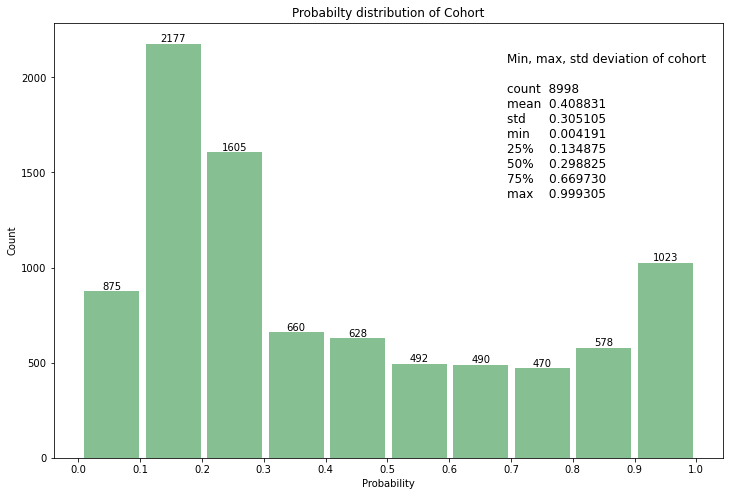

### Demonstrate demographic characteristics of analytical cohort


Below we show the steps to collect demographic characterstics based on the responses to `Basics` survey at the time of enrollment and how to merge them with analytical cohort that was created to compute Long COVID probabilities.

In [ ]:
cohort_demographics = pd.merge(count_dx_pre_and_post , Feature_Table_Builder_df[['person_id','sex', 'race', 'ethn']], on='person_id', how='left')

In [ ]:
cohort_demographics['age_decile'] = ''
cohort_demographics.loc[((cohort_demographics.apprx_age >= 18) & (cohort_demographics.apprx_age < 30)), "age_decile"] = "18 - 29"
cohort_demographics.loc[((cohort_demographics.apprx_age >= 30) & (cohort_demographics.apprx_age < 40)), "age_decile"] = "30 - 39"
cohort_demographics.loc[((cohort_demographics.apprx_age >= 40) & (cohort_demographics.apprx_age < 50)), "age_decile"] = "40 - 49"
cohort_demographics.loc[((cohort_demographics.apprx_age >= 50) & (cohort_demographics.apprx_age < 60)), "age_decile"] = "50 - 59"
cohort_demographics.loc[((cohort_demographics.apprx_age >= 60) & (cohort_demographics.apprx_age < 70)), "age_decile"] = "60 - 69"
cohort_demographics.loc[((cohort_demographics.apprx_age >= 70) & (cohort_demographics.apprx_age < 80)), "age_decile"] = "70 - 79"
cohort_demographics.loc[((cohort_demographics.apprx_age >= 80) & (cohort_demographics.apprx_age < 90)), "age_decile"] = "80 - 89"
cohort_demographics.loc[(cohort_demographics.apprx_age >= 90), "age_decile"] = "90+"

**Demographic Characterisits of cohort**

All demographics are PPI data extracted from the  Basics  Surveys. The participant's Age
was calculated using information provided during the primary consent process. The
demographic data is stored in the CDR  person  and  observation  tables. 

These simple visualizations help in analyzing the cohort.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
people = tuple(count_dx_pre_and_post['person_id'])

In [ ]:
def get_demographic_data(dataset):   
    # SQL query to get participants demographic data
    query = f"""
        SELECT
            DISTINCT person_id
            , LOWER(r.concept_name) AS race
            , LOWER(e.concept_name) AS ethnicity
            , CAST(age_at_cdr AS INTEGER) AS age_at_cdr
            , LOWER(s.concept_name) AS sex_at_birth
            , gender_identity
            , income                                
            , education   
            , employment  

        FROM `{dataset}.person`
        JOIN `{dataset}.concept` r on r.concept_id = race_source_concept_id
        JOIN `{dataset}.concept` e on e.concept_id = ethnicity_concept_id
        JOIN `{dataset}.concept` s on s.concept_id = sex_at_birth_concept_id
        LEFT JOIN `{dataset}.cb_search_person` using(person_id)

        LEFT JOIN (SELECT DISTINCT person_id, LOWER(concept_name) as income
                  FROM `{dataset}.observation`
                  JOIN `{dataset}.concept` on concept_id = value_source_concept_id
                  WHERE observation_source_concept_id = 1585375) using(person_id)

        LEFT JOIN (SELECT DISTINCT person_id, LOWER(concept_name) as gender_identity
                  FROM `{dataset}.observation`
                  JOIN `{dataset}.concept` on concept_id = value_source_concept_id
                  WHERE observation_source_concept_id = 1585838) using(person_id)


        LEFT JOIN (SELECT DISTINCT person_id, LOWER(concept_name) as education
                  FROM `{dataset}.observation` 
                  JOIN `{dataset}.concept` on concept_id = value_source_concept_id
                  where observation_source_concept_id = 1585940) using(person_id) 

        LEFT JOIN (SELECT DISTINCT person_id, LOWER(concept_name) as employment
                  FROM `{dataset}.observation` 
                  JOIN `{dataset}.concept` on concept_id = value_source_concept_id
                  WHERE observation_source_concept_id = 1585952) using(person_id)                           
        where person_id in {people}
        """
    demographics_df = pd.read_gbq(query)
    
    return demographics_df

In [ ]:
def all_persons(dataset):
    
    # Query to get a list of all participants and their data types
    query = f"""

    SELECT 
        DISTINCT p.person_id
    FROM `{dataset}.person` p
    where p.person_id in {people}
    
    """

    all_cdr_pids = pd.read_gbq(query)
    all_cdr_pids = all_cdr_pids.rename(columns = {'Arr':"Array"})

    return all_cdr_pids


In [ ]:
# +
new_field_names = {'race ethnicity none of these'.title():'None Of These'
                    , "sex at birth none of these".title():'None Of These'
                    , "none".title():'None Of These'
                    , 'nhpi'.title():'NHPI (Native Hawaiian and Other Pacific Islander)'
                    , 'mena'.title(): 'MENA (Middle Eastern and North African)'
                    , 'prefer not to answer'.title(): 'Not Specified'
                    , 'i prefer not to answer'.title(): 'Not Specified'
                    , 'no matching concept'.title(): 'Not Specified'
                    , 'additional options'.title(): 'Not Specified'
                    , 'not man only, not woman only, prefer not to answer, or skipped'.title():'Not Specified'
                  }

new_variable_names = {'race': 'Self-Reported Race'
                     , 'sex_at_birth':'Self-Reported Sex at Birth'
                     , 'ethnicity':'Self-Reported Ethnicity'
                     , 'gender_identity':'Self-Reported Gender Identity'
                     , 'age_group':'Age Group at CDR'
                     , 'education':'Self-Reported Educational Attainment'
                     , 'income':'Self-Reported Income'
                     , 'employment':'Self-Reported Employment'
                     }


In [ ]:
####
sex_index_order = ['Female', 'Male', 'Intersex','None Of These', 'Skip', 'Not Specified']

race_index_order = ['White', 'Black', 'Asian', 'MENA (Middle Eastern and North African)'
                     , 'NHPI (Native Hawaiian and Other Pacific Islander)', 'More Than One Population'
                     , 'None Of These', 'Skip', 'Not Specified']

ethnicity_index_order = ['Not Hispanic Or Latino', 'Hispanic Or Latino'
                         ,'None Of These', 'Skip', 'Not Specified']

age_index_order = ['18-29','30-39', '40-49', '50-59','60-69', '70-79', '80-89', '90+']

gender_index_order = ['Woman', 'Man', 'Non Binary', 'Transgender', 'Skip', 'Not Specified']

income_index_order = ['Less 10K', '10K 25K', '25K 35K', '35K 50K', '50K 75K'
                      , '75K 100K','100K 150K', '150K 200K', 'More 200K','Skip', 'Not Specified']

education_index_order = ['Never Attended', 'One Through Four'
                         , 'Five Through Eight','Nine Through Eleven'
                         , 'Twelve Or Ged', 'College One To Three' 
                         , 'College Graduate', 'Advanced Degree'
                         , 'Skip', 'Not Specified']

employment_index_order = ['Employed For Wages', 'Self Employed'
                          , 'Out Of Work One Or More','Out Of Work Less Than One'
                          ,'Student', 'Homemaker','Retired', 'Unable To Work'
                          , 'Skip', 'Not Specified']

In [ ]:
def format_counts(df, n_colname, label_colname, perc_colname):
    
    less_than_20 = df.loc[df[n_colname].astype('int') <20, n_colname]
    df[label_colname] = df[n_colname]
    
    # when counts >20
    df.loc[df[label_colname] >=20, label_colname] = \
                ['{:,}'.format(i).replace('.0','') for i in df.loc[df[label_colname] >=20, label_colname]]
    
    #when counts <20
    df.loc[df[label_colname].isin(less_than_20),label_colname]= '<20'
    df[label_colname] = df[label_colname]+' ('+df[perc_colname+'_f'] +')'
    df.loc[df[label_colname].str.contains('<20'),  label_colname]= '<20'
    
    return df

In [ ]:
def cal_perc(df, denom_df, denom_name,  multiindex_col):
    
    var_col = [c for c in df.columns if 'Self-Reported' in c or 'Age Group at CDR' in c]
        
    n_colname = 'Count of participants '+denom_name
    perc_colname = 'Percentage'
    label_colname = 'Count (and %) of participants '+denom_name


    df_count = df.merge(denom_df)
    df_count = df_count.groupby(var_col).nunique()
    df_count.columns = [n_colname]
    df_count[n_colname] = df_count[n_colname].astype('int').fillna(0)
    df_count = df_count.reset_index()
    df_count[perc_colname] = df_count[n_colname]/denom_df.person_id.nunique()
    df_count[[n_colname, perc_colname]] = df_count[[n_colname, perc_colname]].fillna(0)

    
    total_df = pd.DataFrame(df_count.sum()).T
    total_df[var_col[0]] = 'TOTAL'

    df_count = df_count[var_col+[n_colname,perc_colname]].sort_values(n_colname, ascending = False)
    df_count = pd.concat([df_count, total_df])
    
    df_count[perc_colname+'_f'] = ['{:.2%}'.format(i) for i in df_count[perc_colname]]
    #df_count[label_colname] = ['{:,}'.format(i).replace('.0','') for i in df_count[n_colname]]
    
    df_count = format_counts(df_count, n_colname, label_colname, perc_colname)
    #df_count[label_colname] = df_count[label_colname]+' ('+df_count[perc_colname+'_f'] +')'
    
    df_count = df_count.set_index(var_col[0]).drop([perc_colname+'_f'],1)
    df_count.columns = pd.MultiIndex.from_tuples([(multiindex_col, n_colname)
                                                  , (multiindex_col, perc_colname)
                                                  , (multiindex_col, label_colname)])

    df_count = df_count.fillna(0)
    return df_count


In [ ]:
def get_counts(df, demographic, denom_df, denom_name, multiindex_col):
    
    
    df[demographic] = df[demographic].fillna('Not Specified')
    
    if demographic =='age_at_cdr':
        # create age group similar to that in data browser
        age_bins = [18,29,39,49,59,69,79,89,200]
        age_labels = ["18-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90+"]
        df['age_group'] = pd.cut(df[demographic], bins=age_bins, labels=age_labels
                                           , include_lowest=True)
        df = df.drop(demographic,1)
    else:
        df_multiple_demog = df[['person_id',demographic]].groupby('person_id', as_index = False).nunique()
        df_multiple_demog = df_multiple_demog[df_multiple_demog[demographic] >1]['person_id'].unique()  
        df.loc[df.person_id.isin(df_multiple_demog), demographic] = 'Multiple Selections'
        df = df.drop_duplicates()

        df.loc[df[demographic].str.contains(': '), demographic] = \
            [i.split(': ')[1] for i in df.loc[df[demographic].str.contains(': '), demographic]]

        df[demographic] = [i.title() for i in df[demographic]]
        df[demographic] = df[demographic].replace(new_field_names)     
    
    
    df = df.rename(columns = new_variable_names)    
    df = cal_perc(df = df, denom_df = denom_df, denom_name = denom_name
                  , multiindex_col= multiindex_col)
        
    return df

In [ ]:
def combined_datatypes(demographic, demographics_df, index_order, all_cdr_pids):
    
    # Denominators and Stratificators    
    overall_df = all_cdr_pids[['person_id']].drop_duplicates()
    
    # output
 
    df_plot = pd.concat([get_counts(df = demographics_df[['person_id',demographic]]
                               , demographic = demographic
                               , denom_df = overall_df
                               , denom_name = 'in CDR', multiindex_col = 'OVERALL'
                              )
                        ], True)
    
    #df_plot.index.name = df_plot.index.name.upper()    
    if 'Multiple Selections' in df_plot.index:
        df_plot = df_plot.reindex(index_order+['Multiple Selections']+['TOTAL'])
    else:
        df_plot = df_plot.reindex(index_order+['TOTAL'])
    
    perc_col = [c for c in df_plot.columns if 'Percentage' in c[0] or 'Percentage' in c[1]]
    n_col = [c for c in df_plot.columns if 'Count of participants' in c[0] or 'Count of participants' in c[1]]
    label_col = [c for c in df_plot.columns if '(and %)' in c[0] or '(and %)' in c[1]]

    df_plot[n_col] = df_plot[n_col].fillna(0).astype('int')
    df_plot[perc_col] = df_plot[perc_col].fillna(0)
    df_plot[label_col] = df_plot[label_col].fillna('0')

    # Separating the dataframe into one for table display and one for plotting
    df = df_plot[[c for c in df_plot.columns if 'Count of participants' not in c[0] and 'Count of participants' not in c[1]]]
    df = df[[c for c in df.columns if 'Percentage' not in c[0] and 'Percentage' not in c[1]]]
    return df, df_plot


In [ ]:
def auto_annotate(df_plot, plot, bar_height_col, label_col, ax):        

    for bar in plot.patches:
        vals = df_plot[df_plot[bar_height_col] == bar.get_width()][label_col]
        
        if bar_height_col == 'Percentage':
            val = vals[0]
        else:
            val= vals.iloc[0,0]
        
        max_bar_value = max(df_plot[bar_height_col].values)
        if bar.get_width() == max_bar_value or max_bar_value-bar.get_width() <=0.05:
            ha = 'right'
        else:
            ha = 'left'
        
        ax.annotate(text = val, xy = (bar.get_width(), bar.get_y()+0.2), ha=ha, va='bottom', size=11)

In [ ]:
def bar_subplots(demog_plot_df, w=15, h1 = 4, h2 = 10, color = '#ABD5AB', title = ''): # '#295D8A'
    print('\n')
    
    demog_plot_df = demog_plot_df.rename(index = {'NHPI (Native Hawaiian and Other Pacific Islander)':'NHPI'
                                                 ,'MENA (Middle Eastern and North African)':'MENA'
                                                 , 'More Than One Population':'More Than \nOne Population'
                                                 , 'Not Specified':'Not \nSpecified'
                                                , 'Not Hispanic Or Latino':'Not Hispanic \nOr Latino'
                                                , 'Out Of Work One Or More':'Out Of Work \nOne Or More'
                                                ,'Out Of Work Less Than One': 'Out Of Work \nLess Than One'
                                    })
    
    # 1. Create bar plot for overall counts
    overall_plot = demog_plot_df.iloc[:-1,0:3]
    overall_plot.columns = [c[1] for c in overall_plot.columns]
    plot1 = overall_plot.plot(figsize = (w,h1), y = 'Percentage', legend = False
                                   , kind = 'barh', xlabel = '', color = color, width=0.7)
    plot1.set_title(title)
    plot1.set_xticklabels('')
    plot1.legend(['Overall'], loc = 'best') 
    
  
    auto_annotate(df_plot = overall_plot, plot = plot1, bar_height_col = 'Percentage'
                  , label_col = 'Count (and %) of participants in CDR', ax = plot1)


    plt.show()

In [ ]:
demographics_df = get_demographic_data(dataset = CDR)
demographics_df.shape

In [ ]:
all_cdr_pids = all_persons(dataset = CDR) 
all_cdr_pids.shape

**Race Distribution**

In [ ]:
race_df, race_plot_df = combined_datatypes('race', demographics_df, race_index_order, all_cdr_pids)
bar_subplots(race_plot_df, h1 = 6, h2 = 18, title = 'Race Distribution of Cohort')

In [ ]:
ethn_df, ethn_plot_df = combined_datatypes('ethnicity', demographics_df, ethnicity_index_order, all_cdr_pids)
bar_subplots(ethn_plot_df, h1 = 6, h2 = 18, title = 'Ethnicity Distribution of Cohort')

In [ ]:
sex_df, sex_plot_df = combined_datatypes('sex_at_birth', demographics_df, sex_index_order, all_cdr_pids)
bar_subplots(sex_plot_df, title = 'Sex At Birth Distribution of Cohort')

In [ ]:
age_df, age_plot_df = combined_datatypes('age_at_cdr', demographics_df, age_index_order, all_cdr_pids)
bar_subplots(age_plot_df, h2 = 15, title = 'Age Distribution of Cohort') 

In [ ]:
person_info_query = f"""
        SELECT
            DISTINCT person_id
            , LOWER(r.concept_name) AS race
            , LOWER(e.concept_name) AS ethnicity
            , CAST(age_at_cdr AS INTEGER) AS age_at_cdr
            , LOWER(s.concept_name) AS sex_at_birth,
            case when CAST(age_at_cdr as INTEGER) >= 18 and CAST(age_at_cdr as INTEGER) <= 45 then '18 - 45'
            when CAST(age_at_cdr as INTEGER) > 45 and CAST(age_at_cdr as INTEGER) <= 65 then '46 - 65'
            when CAST(age_at_cdr as INTEGER) >= 66 then '66+'
            else 'Other' end as age_group

        FROM `{CDR}.person`
        JOIN `{CDR}.concept` r on r.concept_id = race_source_concept_id
        JOIN `{CDR}.concept` e on e.concept_id = ethnicity_concept_id
        JOIN `{CDR}.concept` s on s.concept_id = sex_at_birth_concept_id
        LEFT JOIN `{CDR}.cb_search_person` using(person_id)                      
        where person_id in {people}
        """
person_info_df = pd.read_gbq(person_info_query)
person_info_df.head()


In [ ]:
# +
cat_field_names = {'race ethnicity none of these':'None Of These'
                    , "sex at birth none of these":'None Of These'
                    , "none":'Other/Unknown'
                    , 'nhpi':'NHPI (Native Hawaiian and Other Pacific Islander)'
                    , 'mena': 'MENA (Middle Eastern and North African)'
                    , 'prefer not to answer': 'Not Specified'
                    , 'i prefer not to answer': 'Unknown'
                    , 'no matching concept': 'Unknown'
                    , 'additional options': 'Not Specified'
                   ,'pmi: skip': 'Unknown'
                    , 'not man only, not woman only, prefer not to answer, or skipped':'Not Specified',
                   'pmi: prefer not to answer': 'Unknown',
                   'what race ethnicity: black': 'Black',
                   'what race ethnicity: white': 'White',
                   'what race ethnicity: asian': 'Asian',
                   'what race ethnicity: race ethnicity none of these': 'Unknown',
                   'what race ethnicity: nhpi': 'Hawaiian/Pacific Islander',
                   'what race ethnicity: mena': 'Other','skip' : 'Unknown',
                   'intersex': 'Other/Unknown',
                   'more than one population': 'Other'
                  }

In [ ]:
person_info_df['sex_at_birth'] = person_info_df['sex_at_birth'].replace(cat_field_names)
person_info_df['race'] = person_info_df['race'].replace(cat_field_names)
person_info_df['ethnicity'] = person_info_df['ethnicity'].replace(cat_field_names)
person_info_df['race'].unique()

In [ ]:
cd = pd.merge(count_dx_pre_and_post , person_info_df, on='person_id', how='left')

In [ ]:
cd['race'].unique()

In [ ]:
cd[cd['y_pred'] < 0.50].groupby('race')['race'].count()

In [ ]:
cd[(cd['y_pred'] >= 0.50) & (cd['y_pred'] <= 0.75)].groupby('race')['race'].count()

In [ ]:
cd[cd['y_pred'] > 0.75].groupby('race')['race'].count()

## Save the dataframe into bucket
**The code below will save the dataframe = `count_dx_pre_and_post` into the bucket so we can access it in the another notebook to generate reports.** 
On a high-level, this data frame `count_dx_pre_and_post` has person_id, long covid probabilities computed from the ML model, demorgaphics characteristics from `Basics Survey` and features used to train the model. 

In [ ]:
import subprocess
# This snippet assumes you run setup first

# This code saves your dataframe into a csv file in a "data" folder in Google Bucket

# Replace df with THE NAME OF YOUR DATAFRAME
my_dataframe = count_dx_pre_and_post   

# Replace 'test.csv' with THE NAME of the file you're going to store in the bucket (don't delete the quotation marks)
destination_filename = 'count_dx_pre_and_post.csv'

########################################################################
##
################# DON'T CHANGE FROM HERE ###############################
##
########################################################################

# save dataframe in a csv file in the same workspace as the notebook
my_dataframe.to_csv(destination_filename, index=False)

# get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')

# copy csv file to the bucket
args = ["gsutil", "cp", f"./{destination_filename}", f"{my_bucket}/data/"]
output = subprocess.run(args, capture_output=True)

# print output from gsutil
output.stderr


**The code below will save the dataframe = test_data.csv into the bucket so we can access it in the another notebook to generate reports.** This dataframe consists of person_id and long_covid status, which is needed to generate ROC curve in another notebook

In [ ]:
import subprocess  

destination_filename = 'test_data.csv'

test_data.to_csv(destination_filename, index=False)

my_bucket = os.getenv('WORKSPACE_BUCKET')

args = ["gsutil", "cp", f"./{destination_filename}", f"{my_bucket}/data/"]
output = subprocess.run(args, capture_output=True)

output.stderr
